In [1]:
import pandas as pd

from dag_gettsim import tax_transfer
from dag_gettsim.benefits import benefits as child_benefits
from user_functions import (aggregated_benefits, piecewise_income_taxes,
                            unemployment_benefits, unrelated_function,
                            unrelated_function_2, un_unrelated_function,
                           )
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# ==================================================================================
# Create data
# ==================================================================================
index = [
    "rich_person",
    "normal_person",
    "poor_person",
    "many_children",
    "unemployed",
]
data = {
    "income": pd.Series([200_000, 50_000, 10_000, 60_000, 0], index=index),
    "wealth": pd.Series([1_000_000, 50_000, 0, 20_000, 0], index=index),
    "n_children": pd.Series([0, 2, 2, 5, 2], index=index),
}

In [3]:
# ==================================================================================
# Baseline simulation
# ==================================================================================
baseline_result, dag1 = tax_transfer(
    baseline_date="2019-01-01", data=data, targets=["disposable_income"], return_dag=True
)

df = pd.DataFrame(
    {
        "correct": pd.Series([260_000, 45_000, 12_000, 50_000, 4000], index=index),
        "calculated": baseline_result["disposable_income"],
    }
)

print("Baseline Results")
print(df)

Baseline Results
               correct  calculated
rich_person     260000    260000.0
normal_person    45000     45000.0
poor_person      12000     12000.0
many_children    50000     50000.0
unemployed        4000      4000.0


In [4]:
# ==================================================================================
# Replace income_tax by piecewise linear income tax (i.e. replace one function by
# another one with the same interface)
# ==================================================================================

piecewise_result, dag2 = tax_transfer(
    baseline_date="2019-01-01",
    data=data,
    functions={"income_taxes": piecewise_income_taxes},
    params={"tax_10_to_55": 0.2, "tax_above_55": 0.5},
    targets=["disposable_income"],
    return_dag=True,
)

df = pd.DataFrame(
    {
        "correct": pd.Series([200_000, 45_000, 14_000, 32_000, 4000], index=index),
        "calculated": piecewise_result["disposable_income"],
    }
)

print("Piecewise Results")
print(df)

Piecewise Results
               correct  calculated
rich_person     200000    200000.0
normal_person    45000     30000.0
poor_person      14000     14000.0
many_children    32000     32000.0
unemployed        4000      4000.0


C:\tools\miniconda3\envs\dag_gettsim\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


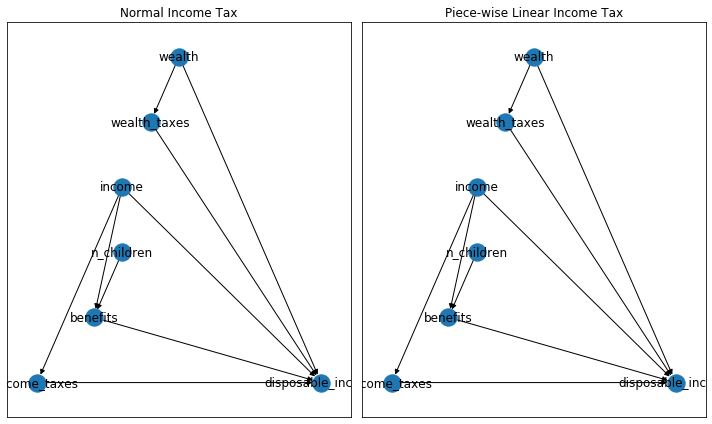

In [5]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10, 6))

nx.draw_networkx(dag1, ax=ax11, pos=nx.planar_layout(dag1))
nx.draw_networkx(dag2, ax=ax12, pos=nx.planar_layout(dag2))

ax11.set_title("Normal Income Tax")
ax12.set_title("Piece-wise Linear Income Tax")

plt.tight_layout()

plt.savefig("income-tax-vs-pwl-income-tax.png")

In [6]:
# ==================================================================================
# Replace benefits by child_benefits and unemployment_benefits, i.e. replace one
# function by two other functions but still re-use as much as possible of the
# existing code)
# ==================================================================================

user_funcs = {
    "child_benefits": child_benefits,
    "unemployment_benefits": unemployment_benefits,
    "benefits": aggregated_benefits,
}

benefit_result, dag3 = tax_transfer(
    baseline_date="2019-01-01",
    data=data,
    functions=user_funcs,
    params={"unemp_benefit": 8_000},
    targets=["disposable_income"],
    return_dag=True
)

df = pd.DataFrame(
    {
        "correct": pd.Series(
            [260_000, 45_000, 12_000, 50_000, 12_000], index=index
        ),
        "calculated": benefit_result["disposable_income"],
    }
)

print("Benefit Results")
print(df)

Benefit Results
               correct  calculated
rich_person     260000    260000.0
normal_person    45000     45000.0
poor_person      12000     12000.0
many_children    50000     50000.0
unemployed       12000     12000.0


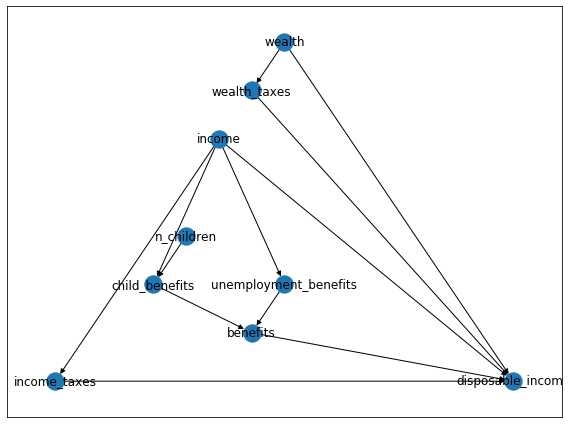

In [7]:
fig, ax3 = plt.subplots(figsize=(8, 6))

nx.draw_networkx(dag3, ax=ax3, pos=nx.planar_layout(dag3))

plt.tight_layout()

In [8]:
# ==================================================================================
# Show automatic pruning of the graph.
# ==================================================================================
baseline_result_unpruned, dag_unpruned = tax_transfer(
    baseline_date="2019-01-01",
    data=data,
    targets="all",
    functions={
        "unrelated_function": unrelated_function,
        "unrelated_function_2": unrelated_function_2,
        "un_unrelated_function": un_unrelated_function,
    },
    return_dag=True
)

baseline_result_pruned, dag_pruned = tax_transfer(
    baseline_date="2019-01-01",
    data=data,
    targets=["disposable_income"],
    functions={
        "unrelated_function": unrelated_function,
        "unrelated_function_2": unrelated_function_2,
        "un_unrelated_function": un_unrelated_function,
    },
    return_dag=True
)

In [9]:
baseline_result_unpruned

{'income': rich_person      200000
 normal_person     50000
 poor_person       10000
 many_children     60000
 unemployed            0
 dtype: int64,
 'wealth': rich_person      1000000
 normal_person      50000
 poor_person            0
 many_children      20000
 unemployed             0
 dtype: int64,
 'n_children': rich_person      0
 normal_person    2
 poor_person      2
 many_children    5
 unemployed       2
 dtype: int64,
 'wealth_taxes': rich_person      900000.0
 normal_person     45000.0
 poor_person           0.0
 many_children     18000.0
 unemployed            0.0
 dtype: float64,
 'unrelated_function': 0,
 'unrelated_function_2': 1,
 'benefits': rich_person         0.0
 normal_person       0.0
 poor_person      4000.0
 many_children       0.0
 unemployed       4000.0
 dtype: float64,
 'income_taxes': rich_person      40000.0
 normal_person    10000.0
 poor_person       2000.0
 many_children    12000.0
 unemployed           0.0
 dtype: float64,
 'disposable_income': rich_

In [10]:
# Because of garbage collection.
baseline_result_pruned

{'disposable_income': rich_person      260000.0
 normal_person     45000.0
 poor_person       12000.0
 many_children     50000.0
 unemployed         4000.0
 dtype: float64}

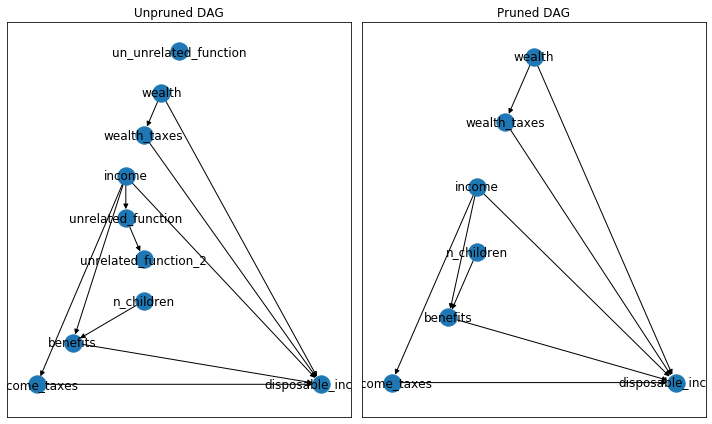

In [11]:
fig, (ax41, ax42) = plt.subplots(1, 2, figsize=(10, 6))

nx.draw_networkx(dag_unpruned, ax=ax41, pos=nx.planar_layout(dag_unpruned))
nx.draw_networkx(dag_pruned, ax=ax42, pos=nx.planar_layout(dag_pruned))

ax41.set_title("Unpruned DAG")
ax42.set_title("Pruned DAG")

plt.tight_layout()

plt.savefig("unpruned-vs-pruned.png")